In [36]:
%matplotlib inline

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
dataset_path = keras.utils.get_file('auto-mpg.data',"https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 6us/step


'C:\\Users\\wegam\\.keras\\datasets\\auto-mpg.data'

In [8]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values = "?", comment='\t',
                          sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [10]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [12]:
dataset = dataset.dropna()

In [15]:
origin = dataset['Origin']
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,1.0,0.0,0.0


In [87]:
train_dataset = dataset.sample(frac=0.6,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

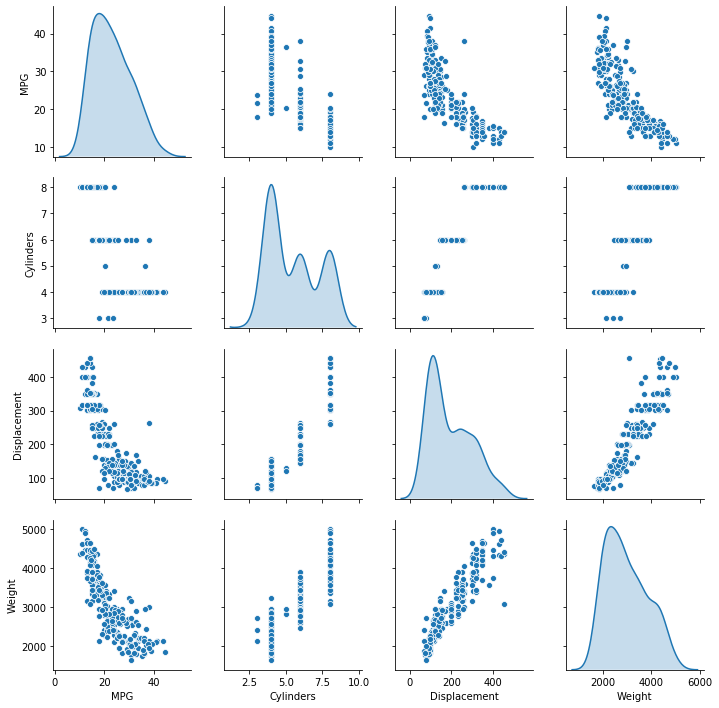

In [88]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind='kde')

In [89]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,235.0,5.519149,1.687895,3.0,4.0,6.0,8.0,8.0
Displacement,235.0,196.434043,103.094715,68.0,107.0,155.0,261.0,455.0
Horsepower,235.0,104.957447,37.989291,46.0,76.0,95.0,129.0,225.0
Weight,235.0,2991.165957,839.469059,1649.0,2264.5,2830.0,3609.0,4997.0
Acceleration,235.0,15.529362,2.600039,8.5,14.0,15.5,17.2,24.6
Model Year,235.0,75.910638,3.650971,70.0,73.0,76.0,79.0,82.0
Origin,235.0,1.557447,0.805893,1.0,1.0,1.0,2.0,3.0
USA,235.0,0.642553,0.480271,0.0,0.0,1.0,1.0,1.0
Europe,235.0,0.157447,0.364999,0.0,0.0,0.0,0.0,1.0
Japan,235.0,0.200000,0.400854,0.0,0.0,0.0,0.0,1.0


In [90]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [91]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [92]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)]
    )

    optimizer = keras.optimizers.RMSprop(0.001)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [93]:
model = build_model()

In [94]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                704       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


In [95]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.32148162],
       [ 0.226194  ],
       [-0.2845328 ],
       [ 0.38473454],
       [ 0.00327483],
       [ 0.0441792 ],
       [ 0.04084302],
       [ 0.14171219],
       [ 0.1246167 ],
       [ 0.13900152]], dtype=float32)

In [96]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('')
        print('.', end='')

In [97]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [98]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
0,583.139111,22.911566,583.139099,441.937929,20.053507,441.937927,0
1,534.524104,21.808241,534.524109,402.641184,19.045799,402.641205,1
2,490.374655,20.775095,490.374664,362.436577,17.964567,362.436584,2
3,444.697963,19.653442,444.697968,321.108591,16.781334,321.108582,3
4,396.006961,18.392075,396.006989,277.490441,15.454790,277.490448,4


In [99]:
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.071031,0.948409,2.071031,13.407905,2.623057,13.407905,995
996,2.018131,0.944578,2.018131,12.078620,2.468515,12.078620,996
997,1.883714,0.902321,1.883715,14.314639,2.654337,14.314639,997
998,1.992274,0.969227,1.992274,12.411419,2.521044,12.411419,998
999,2.316659,1.079377,2.316659,13.436751,2.674588,13.436750,999


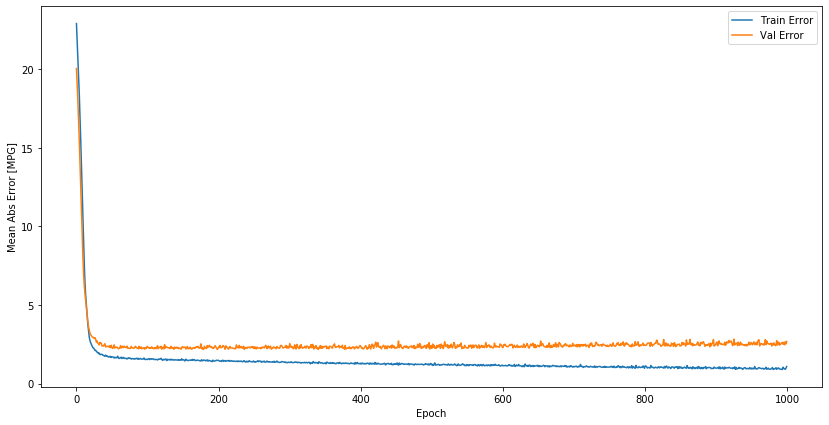

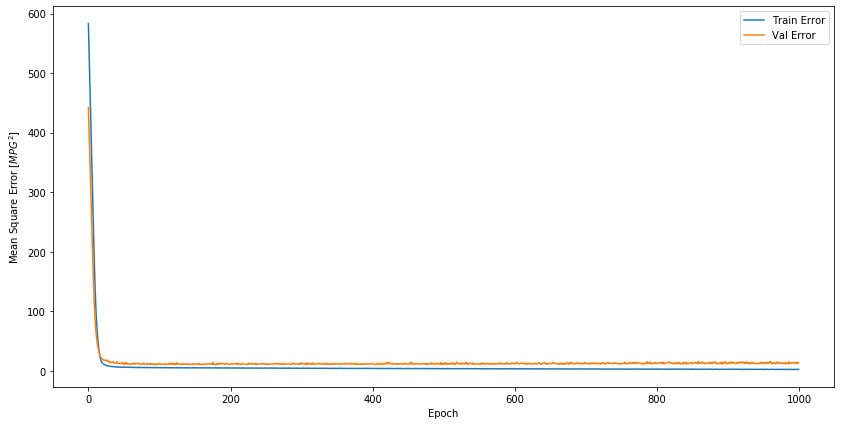

In [100]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure(figsize=(14, 7))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
             label = 'Val Error')
    plt.legend()
  
    plt.figure(figsize=(14, 7))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
             label = 'Val Error')
    plt.legend()
    plt.show()


plot_history(history)


............................................................

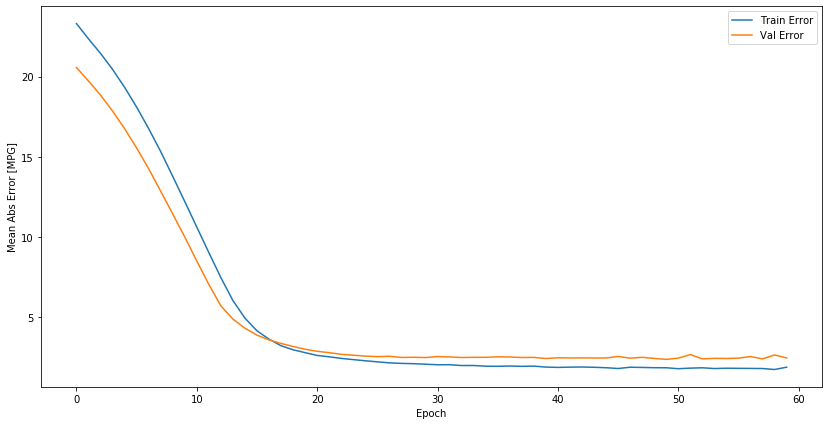

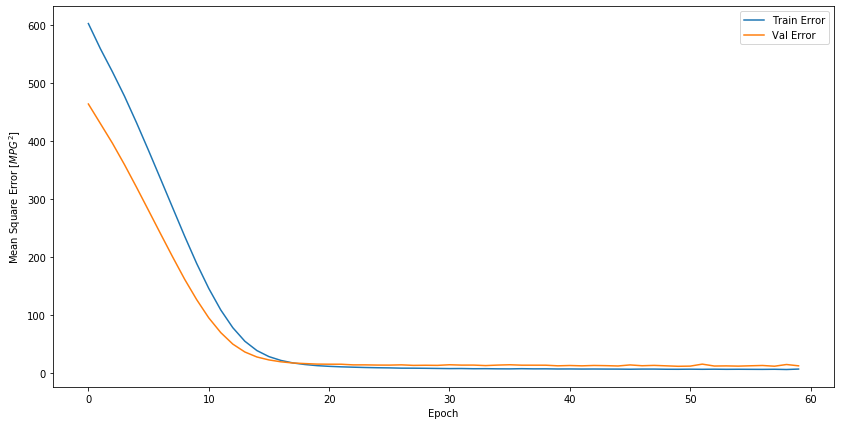

In [101]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [102]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("Testing set Mean Square Error: {:5.2f} MPG".format(mse))

Testing set Mean Abs Error:  1.97 MPG
Testing set Mean Square Error:  7.28 MPG


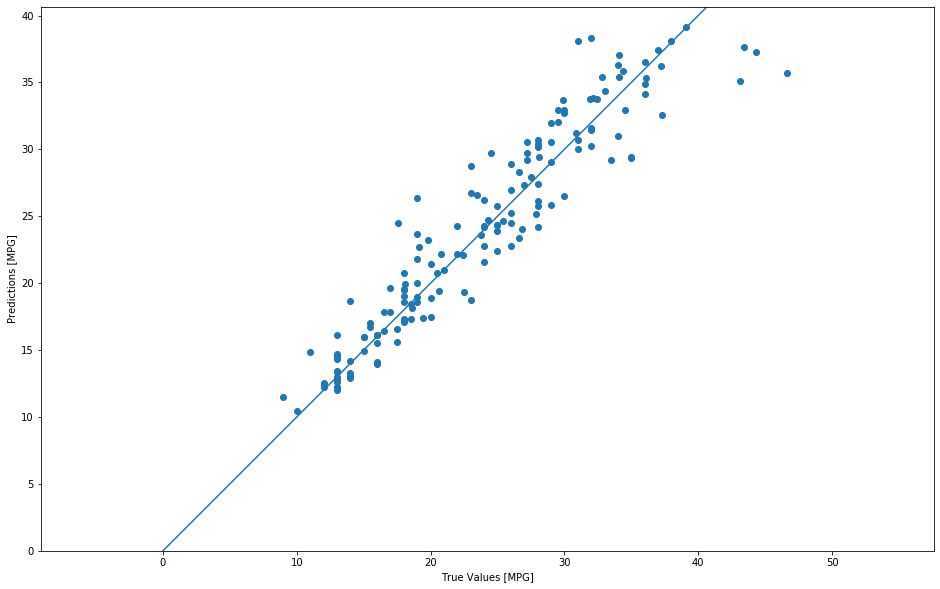

In [103]:
test_predictions = model.predict(normed_test_data).flatten()
plt.figure(figsize=(16, 10))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
#plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

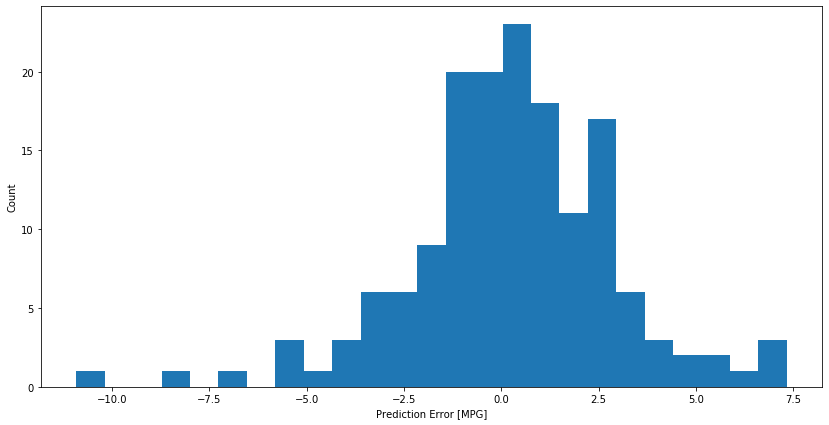

In [104]:
error = test_predictions - test_labels
plt.figure(figsize=(14, 7))
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")